In [1]:
import boost_histogram as bh
import numpy as np
from skhep_testdata import data_path
import uproot
import matplotlib.pyplot as plt

In [2]:
filename = data_path("uproot-hepdata-example.root")
f = uproot.open(filename)

In [3]:
print(*f)

b'hpx;1' b'hpxpy;1' b'hprof;1' b'ntuple;1'


In [4]:
hpx = f['hpx']
hpxpy = f['hpxpy']
hprof = f['hprof']
ntuple = f['ntuple']

In [5]:
def edges_to_axes(edges: np.array) -> bh.axis.Axis:
    """
    Detects regular binning and under/overflow
    """
    underflow = edges[0] == -np.infty
    overflow  = edges[-1] == np.infty
    real_edges = edges[int(underflow):-1 if overflow else None]
    variable = bh.axis.Variable(real_edges, underflow=underflow, overflow=overflow)
    regular = bh.axis.Regular(len(real_edges) - 1, real_edges[0], real_edges[-1], underflow=underflow, overflow=overflow)
    
    return regular if np.allclose(variable, regular) else variable

In [6]:
# TODO: Should work, IMO
# h[...] = np.array([hpx.allvalues, hpx.allvariances]).T

In [7]:
def read_in(rhist):
    alledges = rhist.alledges if isinstance(rhist.alledges, tuple) else (rhist.alledges,)
    h = bh.Histogram(*(edges_to_axes(a) for a in alledges), storage=bh.storage.Weight())
    
    view = h.view(flow=True)
    view.value = rhist.allvalues
    view.variance = rhist.allvariances
    
    return h

In [8]:
bhpx = read_in(hpx)
bhpxpy = read_in(hpxpy)

In [9]:
bhpx_f = bh.Histogram(bh.axis.Regular(100, -4, 4), storage=bh.storage.Weight())
bhpx_f.fill(ntuple["px"].array())

Histogram(Regular(100, -4, 4), storage=Weight()) # Sum: WeightedSum(value=74994, variance=74994) (WeightedSum(value=75000, variance=75000) with flow)

In [10]:
bhpxpy_f = bh.Histogram(bh.axis.Regular(40, -4, 4), bh.axis.Regular(40, -4, 4), storage=bh.storage.Weight())
bhpxpy_f.fill(ntuple["px"].array(), ntuple["py"].array())

Histogram(
  Regular(40, -4, 4),
  Regular(40, -4, 4),
  storage=Weight()) # Sum: WeightedSum(value=74985, variance=74985) (WeightedSum(value=75000, variance=75000) with flow)

In [11]:
assert np.allclose(bhpx_f.view().value, bhpx.view().value)
assert np.allclose(bhpx_f.view().variance, bhpx.view().variance)

In [12]:
assert np.allclose(bhpxpy_f.view().value, bhpxpy.view().value)
assert np.allclose(bhpxpy_f.view().variance, bhpxpy.view().variance)

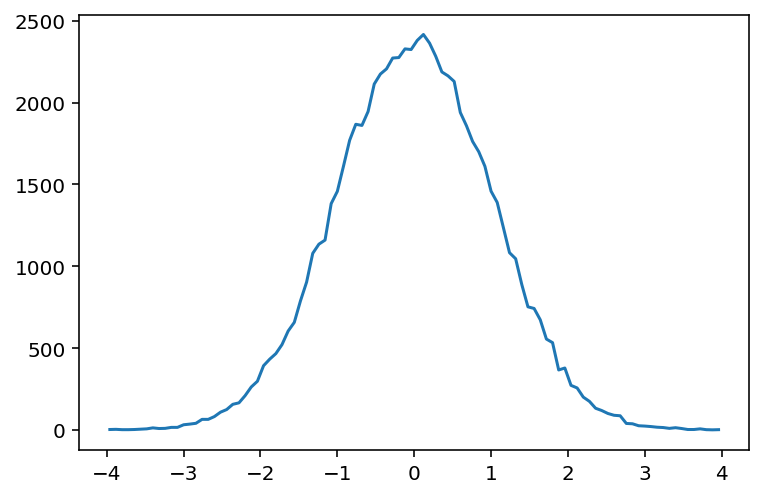

In [13]:
plt.plot(*bhpx_f.axes.centers, bhpx_f.view().value);